<a href="https://colab.research.google.com/github/fralfaro/r4ds-book/blob/main/docs/24_model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model building

## Introduction

In the previous chapter you learned how linear models work, and learned some basic tools for understanding what a model is telling you about your data. The previous chapter focussed on simulated datasets. This chapter will focus on real data, showing you how you can progressively build up a model to aid your understanding of the data.

We will take advantage of the fact that you can think about a model partitioning your data into pattern and residuals. We'll find patterns with visualisation, then make them concrete and precise with a model. We'll then repeat the process, but replace the old response variable with the residuals from the model. The goal is to transition from implicit knowledge in the data and your head to explicit knowledge in a quantitative model. This makes it easier to apply to new domains, and easier for others to use. 

For very large and complex datasets this will be a lot of work. There are certainly alternative approaches - a more machine learning approach is simply to focus on the predictive ability of the model. These approaches tend to produce black boxes: the model does a really good job at generating predictions, but you don't know why. This is a totally reasonable approach, but it does make it hard to apply your real world knowledge to the model. That, in turn, makes it difficult to assess whether or not the model will continue to work in the long-term, as fundamentals change. For most real models, I'd expect you to use some combination of this approach and a more classic automated approach.

It's a challenge to know when to stop. You need to figure out when your model is good enough, and when additional investment is unlikely to pay off. I particularly like this quote from reddit user Broseidon241: 

> A long time ago in art class, my teacher told me "An artist needs to know 
> when a piece is done. You can't tweak something into perfection - wrap it up. 
> If you don't like it, do it over again. Otherwise begin something new". Later
> in life, I heard "A poor seamstress makes many mistakes. A good seamstress 
> works hard to correct those mistakes. A great seamstress isn't afraid to 
> throw out the garment and start over."
> 
> -- Broseidon241, <https://www.reddit.com/r/datascience/comments/4irajq>

### Prerequisites

We'll use the same tools as in the previous chapter, but add in some real datasets: `diamonds` from ggplot2, and `flights` from nycflights13.  We'll also need lubridate in order to work with the date/times in `flights`.



In [8]:
install.packages("nycflights13")
install.packages("hexbin")
library("hexbin")
library(tidyverse)
library(modelr)
#options(na.action = na.warn)

library(nycflights13)
library(lubridate)


## Why are low quality diamonds more expensive? 

In previous chapters we've seen a surprising relationship between the quality of diamonds and their price: low quality diamonds (poor cuts, bad colours, and inferior clarity) have higher prices.



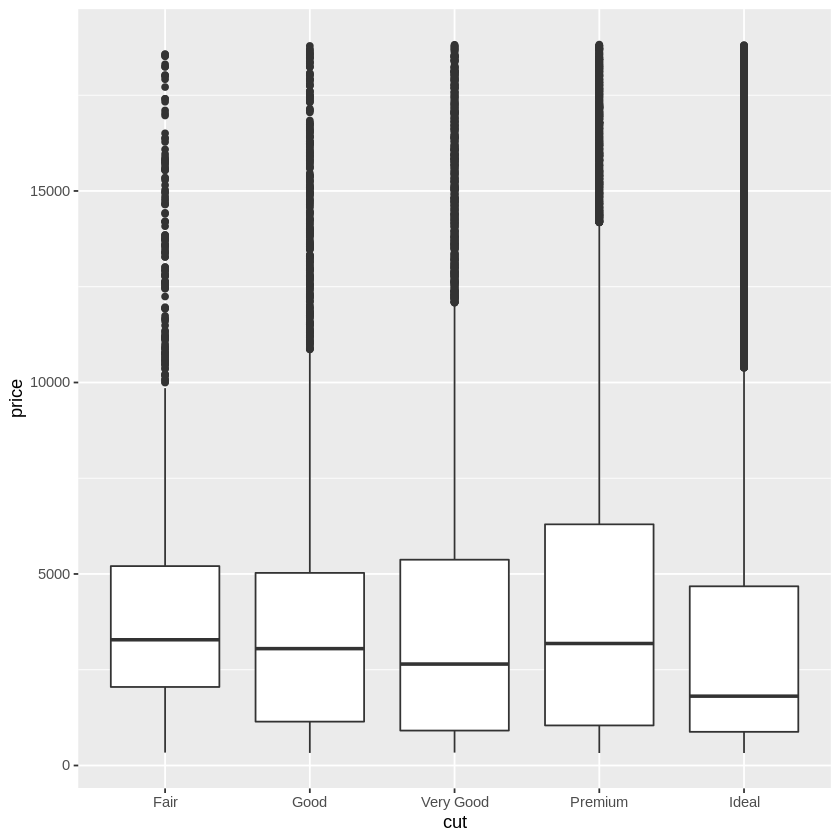

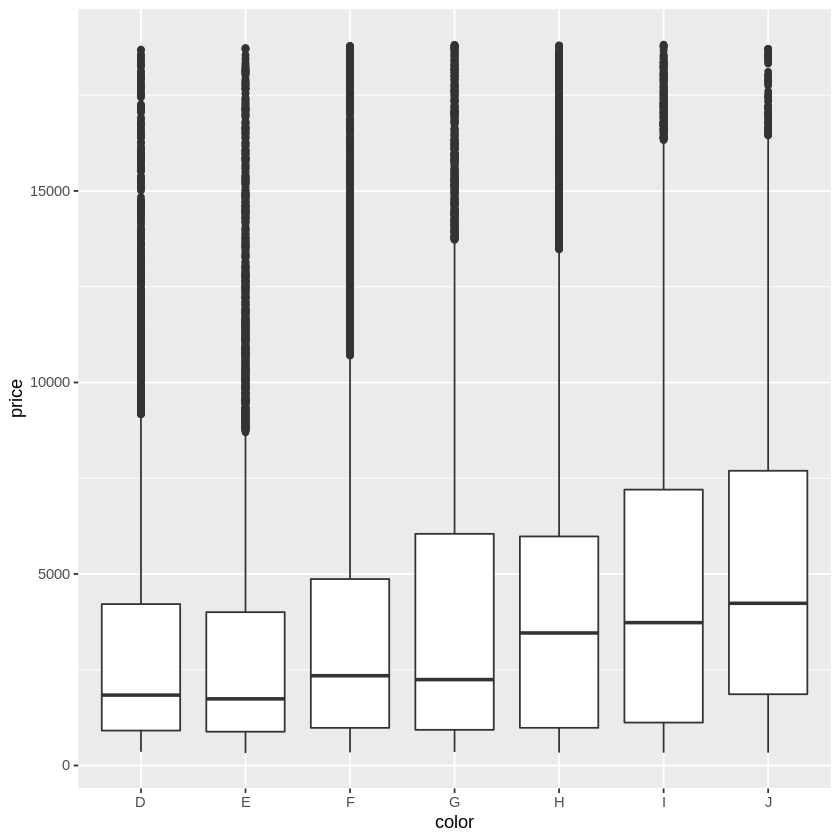

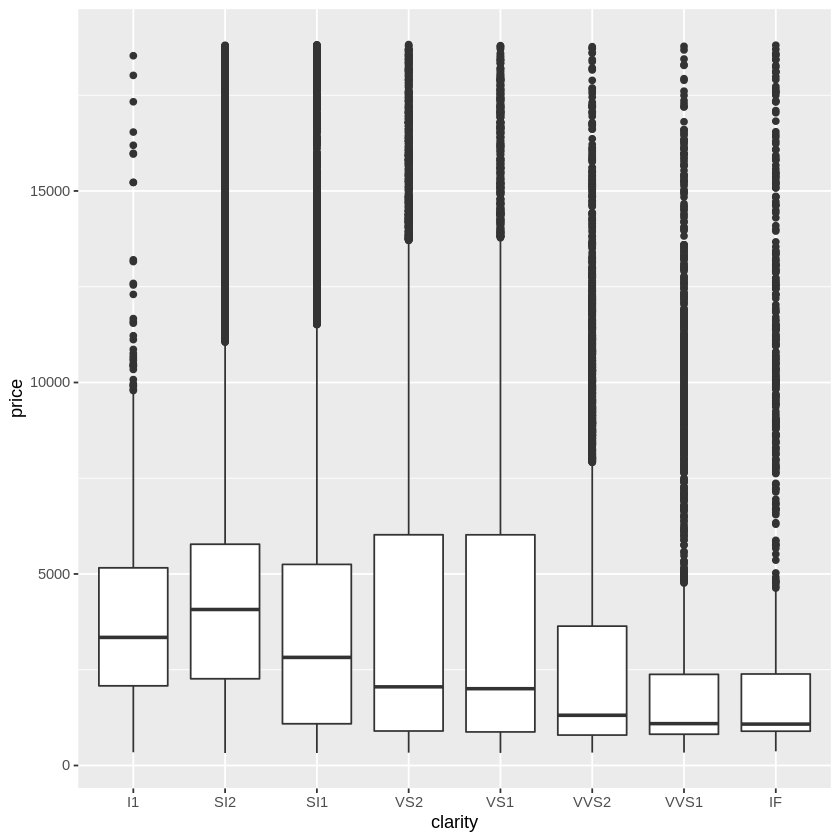

In [9]:
ggplot(diamonds, aes(cut, price)) + geom_boxplot()
ggplot(diamonds, aes(color, price)) + geom_boxplot()
ggplot(diamonds, aes(clarity, price)) + geom_boxplot()


Note that the worst diamond color is J (slightly yellow), and the worst clarity is I1 (inclusions visible to the naked eye).

### Price and carat

It looks like lower quality diamonds have higher prices because there is an important confounding variable: the weight (`carat`) of the diamond. The weight of the diamond is the single most important factor for determining the price of the diamond, and lower quality diamonds tend to be larger.



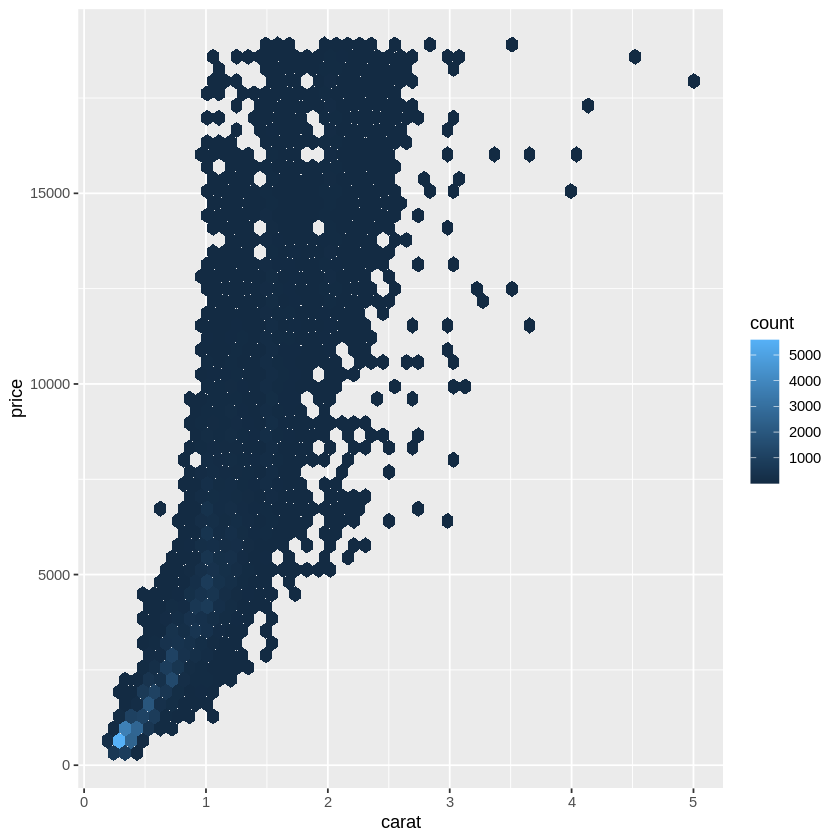

In [14]:
ggplot(diamonds, aes(carat, price)) + 
  geom_hex(bins = 50)


We can make it easier to see how the other attributes of a diamond affect its relative `price` by fitting a model to separate out the effect of `carat`. But first, lets make a couple of tweaks to the diamonds dataset to make it easier to work with:

1. Focus on diamonds smaller than 2.5 carats (99.7% of the data)
1. Log-transform the carat and price variables.


In [15]:
diamonds2 <- diamonds %>% 
  filter(carat <= 2.5) %>% 
  mutate(lprice = log2(price), lcarat = log2(carat))


Together, these changes make it easier to see the relationship between `carat` and `price`:


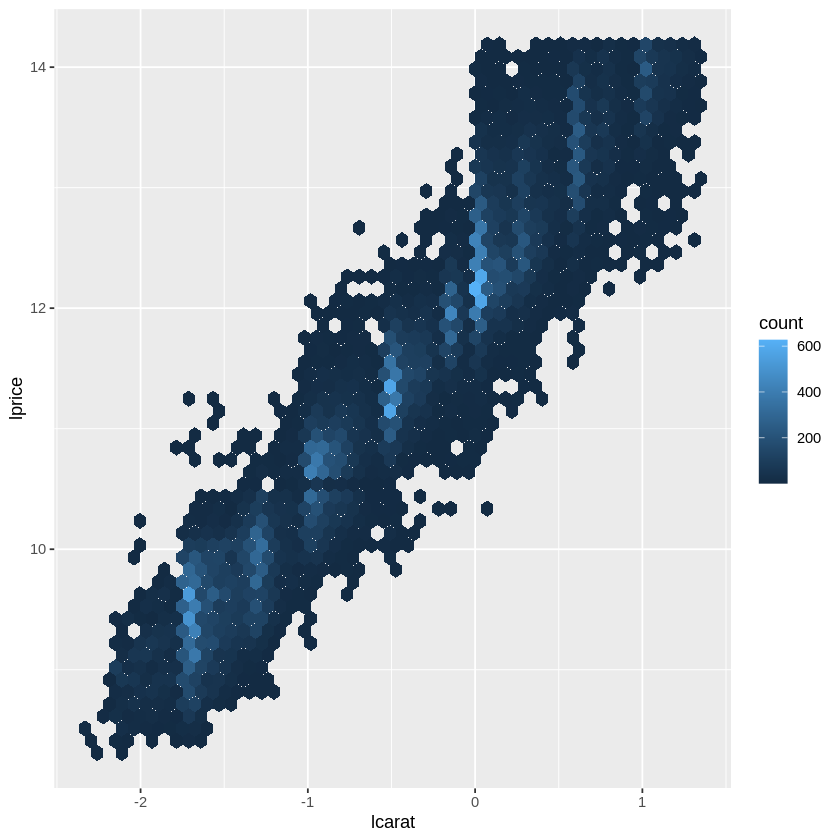

In [16]:
ggplot(diamonds2, aes(lcarat, lprice)) + 
  geom_hex(bins = 50)


The log-transformation is particularly useful here because it makes the pattern linear, and linear patterns are the easiest to work with. Let's take the next step and remove that strong linear pattern. We first make the pattern explicit by fitting a model:



In [17]:
mod_diamond <- lm(lprice ~ lcarat, data = diamonds2)


Then we look at what the model tells us about the data. Note that I back transform the predictions, undoing the log transformation, so I can overlay the predictions on the raw data:



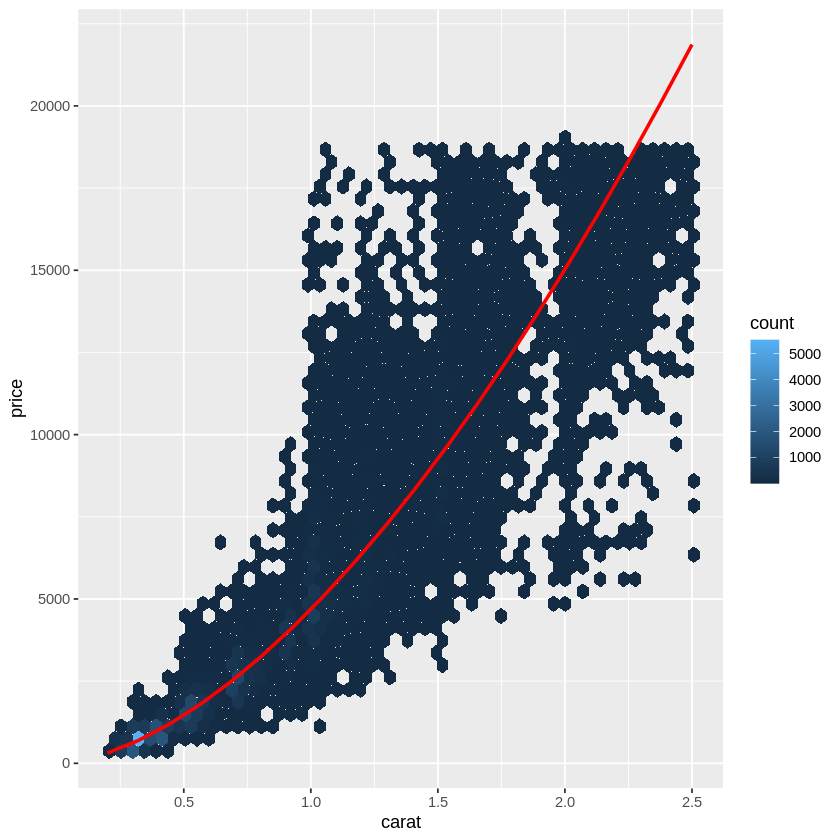

In [18]:
grid <- diamonds2 %>% 
  data_grid(carat = seq_range(carat, 20)) %>% 
  mutate(lcarat = log2(carat)) %>% 
  add_predictions(mod_diamond, "lprice") %>% 
  mutate(price = 2 ^ lprice)

ggplot(diamonds2, aes(carat, price)) + 
  geom_hex(bins = 50) + 
  geom_line(data = grid, colour = "red", size = 1)


That tells us something interesting about our data. If we believe our model, then the large diamonds are much cheaper than expected. This is probably because no diamond in this dataset costs more than $19,000.

Now we can look at the residuals, which verifies that we've successfully removed the strong linear pattern:



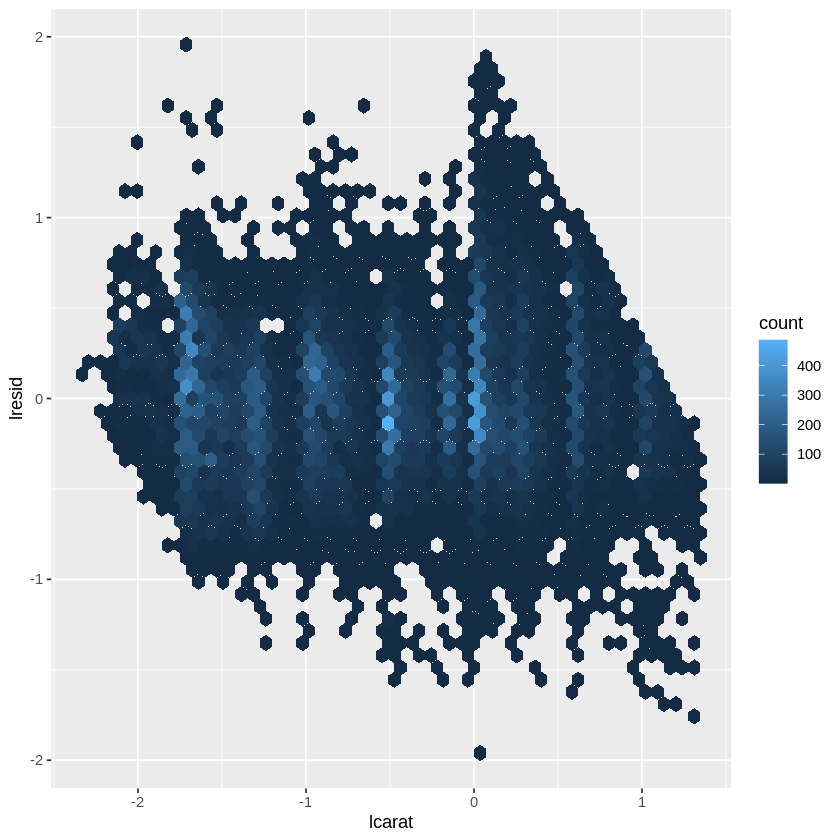

In [19]:
diamonds2 <- diamonds2 %>% 
  add_residuals(mod_diamond, "lresid")

ggplot(diamonds2, aes(lcarat, lresid)) + 
  geom_hex(bins = 50)


Importantly, we can now re-do our motivating plots using those residuals instead of `price`. 



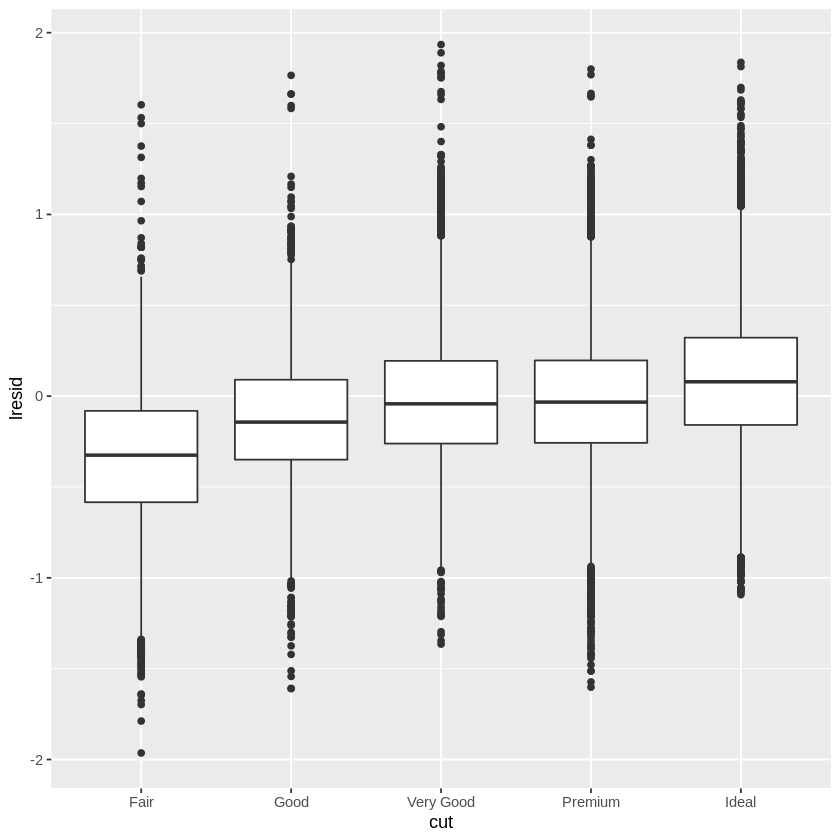

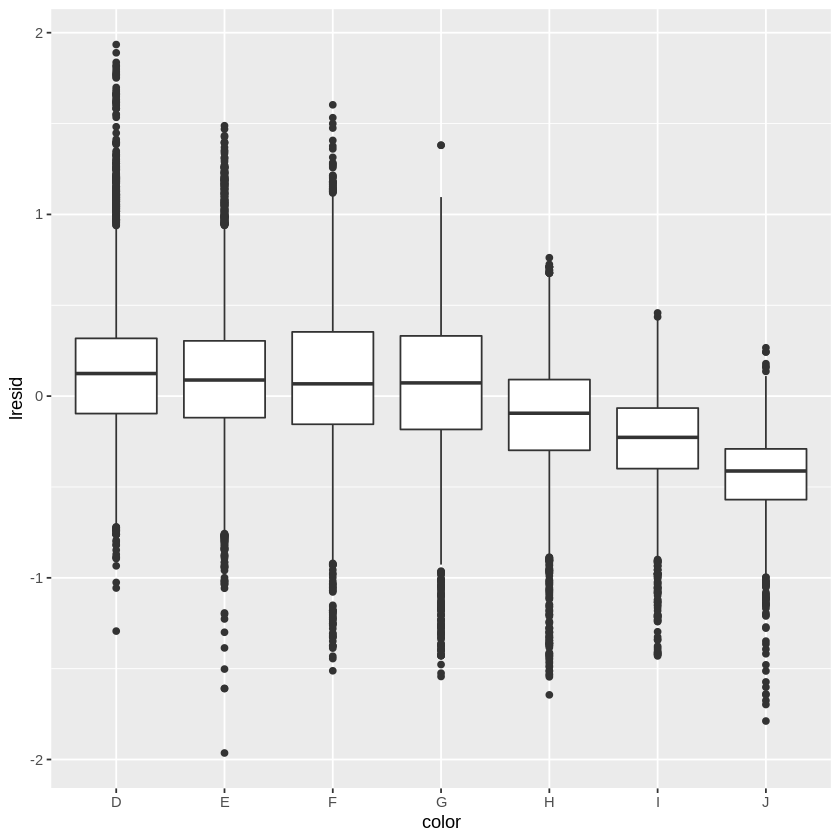

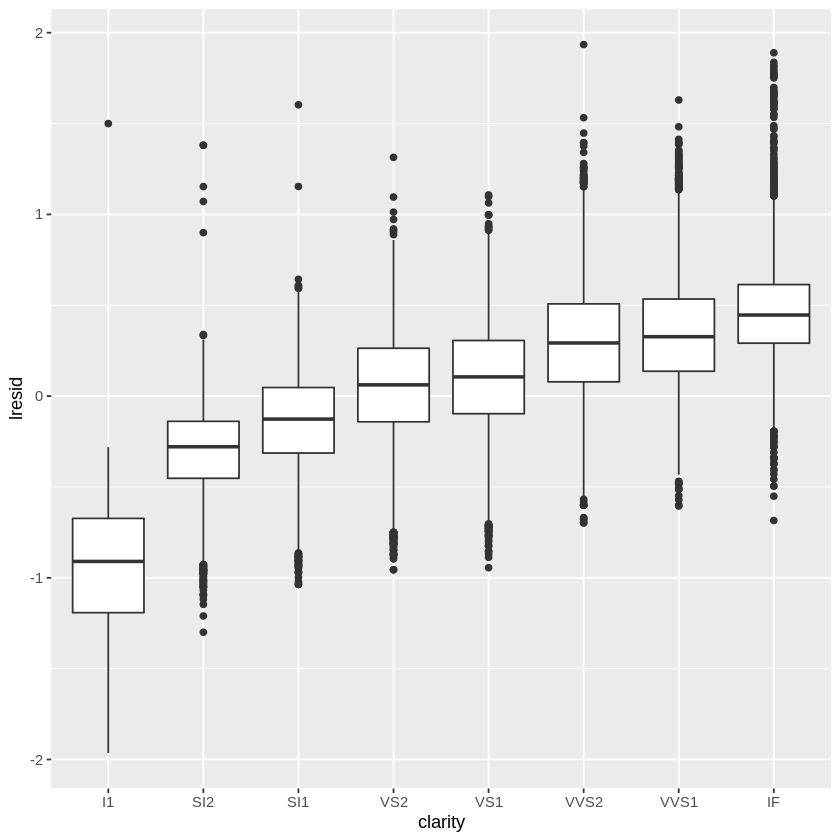

In [20]:
ggplot(diamonds2, aes(cut, lresid)) + geom_boxplot()
ggplot(diamonds2, aes(color, lresid)) + geom_boxplot()
ggplot(diamonds2, aes(clarity, lresid)) + geom_boxplot()


Now we see the relationship we expect: as the quality of the diamond increases, so too does its relative price. To interpret the `y` axis, we need to think about what the residuals are telling us, and what scale they are on. A residual of -1 indicates that `lprice` was 1 unit lower than a prediction based solely on its weight. $2^{-1}$ is 1/2, points with a value of -1 are half the expected price, and residuals with value 1 are twice the predicted price.

### A more complicated model

If we wanted to, we could continue to build up our model, moving the effects we've observed into the model to make them explicit. For example, we could include `color`, `cut`, and `clarity` into the model so that we also make explicit the effect of these three categorical variables:



In [21]:
mod_diamond2 <- lm(lprice ~ lcarat + color + cut + clarity, data = diamonds2)



This model now includes four predictors, so it's getting harder to visualise. Fortunately, they're currently all independent which means that we can plot them individually in four plots. To make the process a little easier, we're going to use the `.model` argument to `data_grid`:



In [23]:
grid <- diamonds2 %>% 
  data_grid(cut, .model = mod_diamond2) %>% 
  add_predictions(mod_diamond2)
grid

cut,lcarat,color,clarity,pred
<ord>,<dbl>,<chr>,<chr>,<dbl>
Fair,-0.5145732,G,VS2,11.20557
Good,-0.5145732,G,VS2,11.32050
Very Good,-0.5145732,G,VS2,11.37396
Premium,-0.5145732,G,VS2,11.40627
Ideal,-0.5145732,G,VS2,11.43759


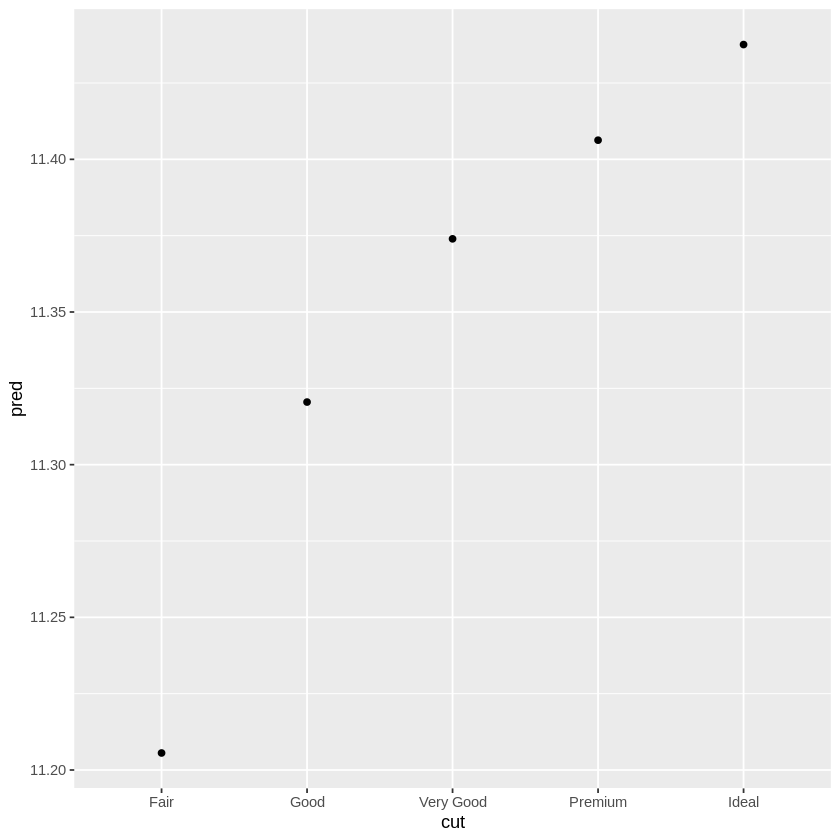

In [24]:

ggplot(grid, aes(cut, pred)) + 
  geom_point()


If the model needs variables that you haven't explicitly supplied, `data_grid()` will automatically fill them in with "typical" value. For continuous variables, it uses the median, and categorical variables it uses the most common value (or values, if there's a tie).


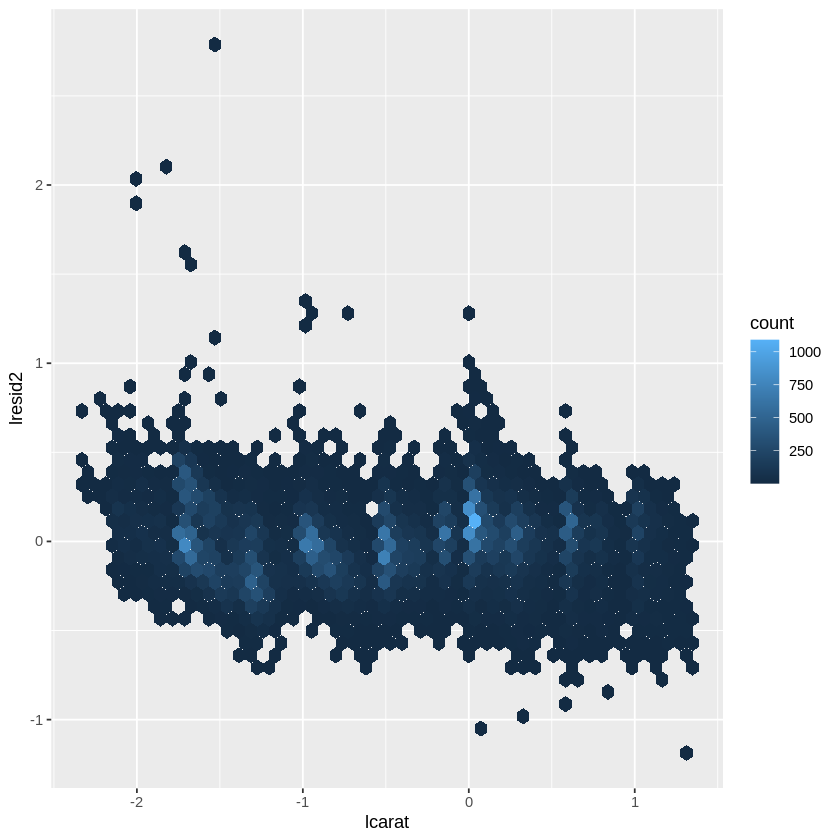

In [25]:
diamonds2 <- diamonds2 %>% 
  add_residuals(mod_diamond2, "lresid2")

ggplot(diamonds2, aes(lcarat, lresid2)) + 
  geom_hex(bins = 50)


This plot indicates that there are some diamonds with quite large residuals - remember a residual of 2 indicates that the diamond is 4x the price that we expected. It's often useful to look at unusual values individually:


In [26]:
diamonds2 %>% 
  filter(abs(lresid2) > 1) %>% 
  add_predictions(mod_diamond2) %>% 
  mutate(pred = round(2 ^ pred)) %>% 
  select(price, pred, carat:table, x:z) %>% 
  arrange(price)

price,pred,carat,cut,color,clarity,depth,table,x,y,z
<int>,<dbl>,<dbl>,<ord>,<ord>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1013,264,0.25,Fair,F,SI2,54.4,64,4.30,4.23,2.32
1186,284,0.25,Premium,G,SI2,59.0,60,5.33,5.28,3.12
1186,284,0.25,Premium,G,SI2,58.8,60,5.33,5.28,3.12
1262,2644,1.03,Fair,E,I1,78.2,54,5.72,5.59,4.42
1415,639,0.35,Fair,G,VS2,65.9,54,5.57,5.53,3.66
1415,639,0.35,Fair,G,VS2,65.9,54,5.57,5.53,3.66
1715,576,0.32,Fair,F,VS2,59.6,60,4.42,4.34,2.61
1776,412,0.29,Fair,F,SI1,55.8,60,4.48,4.41,2.48
2160,314,0.34,Fair,F,I1,55.8,62,4.72,4.60,2.60



Nothing really jumps out at me here, but it's probably worth spending time considering if this indicates a problem with our model, or if there are errors in the data. If there are mistakes in the data, this could be an opportunity to buy diamonds that have been priced low incorrectly.

### Exercises

1.  In the plot of `lcarat` vs. `lprice`, there are some bright vertical
    strips. What do they represent?

1.  If `log(price) = a_0 + a_1 * log(carat)`, what does that say about 
    the relationship between `price` and `carat`?
    
1.  Extract the diamonds that have very high and very low residuals. 
    Is there anything unusual about these diamonds? Are they particularly bad
    or good, or do you think these are pricing errors?

1.  Does the final model, `mod_diamond2`, do a good job of predicting
    diamond prices? Would you trust it to tell you how much to spend
    if you were buying a diamond?

## What affects the number of daily flights?

Let's work through a similar process for a dataset that seems even simpler at first glance: the number of flights that leave NYC per day. This is a really small dataset --- only 365 rows and 2 columns --- and we're not going to end up with a fully realised model, but as you'll see, the steps along the way will help us better understand the data. Let's get started by counting the number of flights per day and visualising it with ggplot2.



In [27]:
daily <- flights %>% 
  mutate(date = make_date(year, month, day)) %>% 
  group_by(date) %>% 
  summarise(n = n())
daily

date,n
<date>,<int>
2013-01-01,842
2013-01-02,943
2013-01-03,914
2013-01-04,915
2013-01-05,720
2013-01-06,832
2013-01-07,933
2013-01-08,899
2013-01-09,902


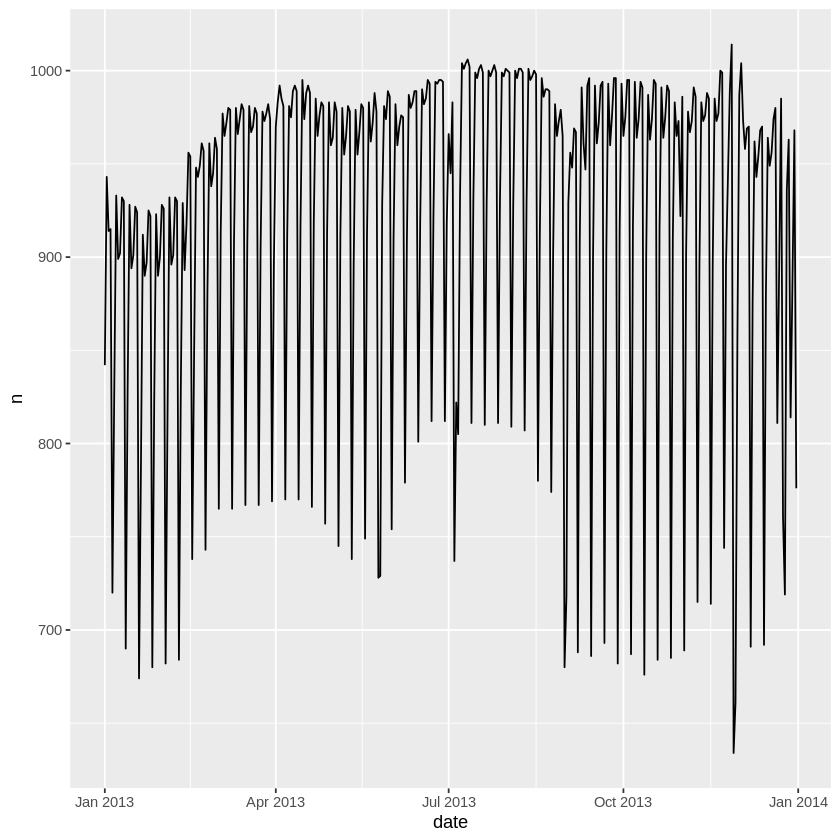

In [28]:
ggplot(daily, aes(date, n)) + 
  geom_line()


### Day of week

Understanding the long-term trend is challenging because there's a very strong day-of-week effect that dominates the subtler patterns. Let's start by looking at the distribution of flight numbers by day-of-week:



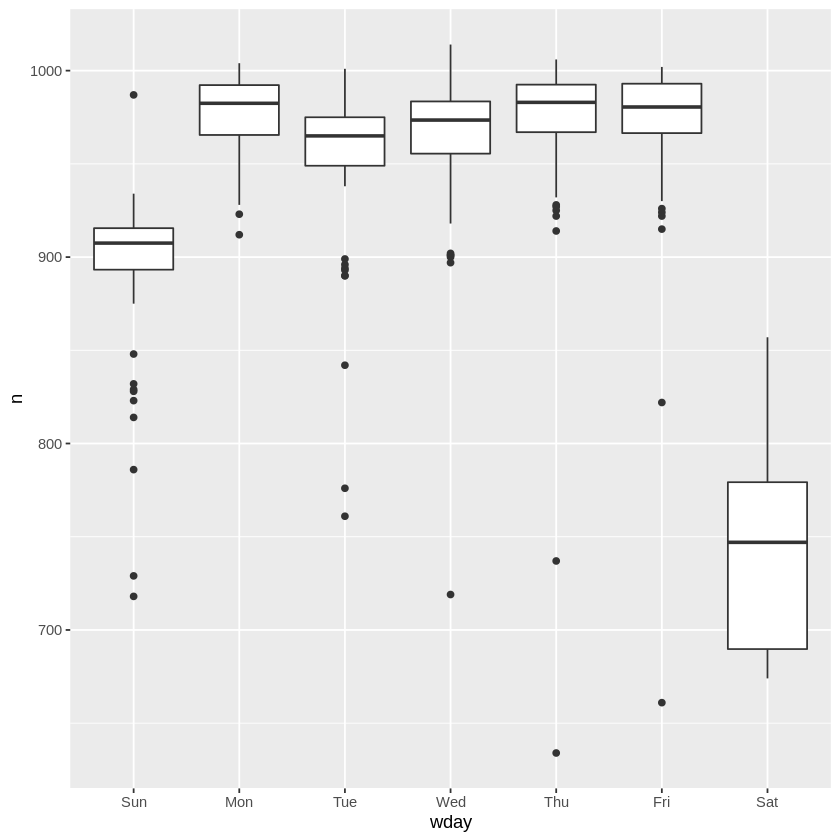

In [29]:
daily <- daily %>% 
  mutate(wday = wday(date, label = TRUE))
ggplot(daily, aes(wday, n)) + 
  geom_boxplot()


There are fewer flights on weekends because most travel is for business. The effect is particularly pronounced on Saturday: you might sometimes leave on Sunday for a Monday morning meeting, but it's very rare that you'd leave on Saturday as you'd much rather be at home with your family.

One way to remove this strong pattern is to use a model. First, we fit the model, and display its predictions overlaid on the original data:


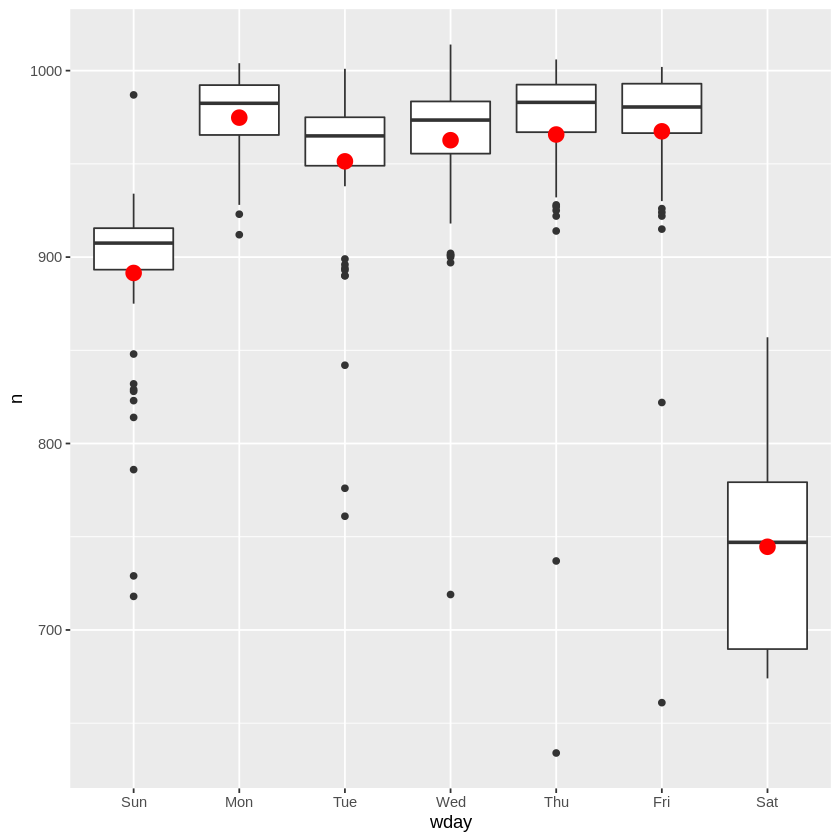

In [30]:
mod <- lm(n ~ wday, data = daily)

grid <- daily %>% 
  data_grid(wday) %>% 
  add_predictions(mod, "n")

ggplot(daily, aes(wday, n)) + 
  geom_boxplot() +
  geom_point(data = grid, colour = "red", size = 4)


Next we compute and visualise the residuals:



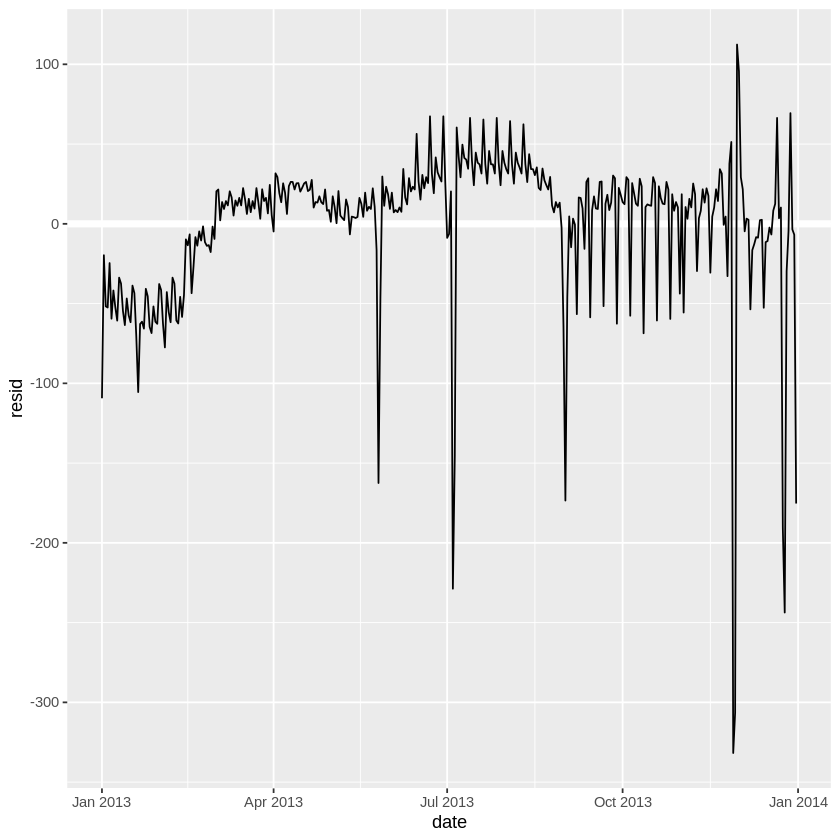

In [31]:
daily <- daily %>% 
  add_residuals(mod)
daily %>% 
  ggplot(aes(date, resid)) + 
  geom_ref_line(h = 0) + 
  geom_line()


Note the change in the y-axis: now we are seeing the deviation from the expected number of flights, given the day of week. This plot is useful because now that we've removed much of the large day-of-week effect, we can see some of the subtler patterns that remain:

1.  Our model seems to fail starting in June: you can still see a strong 
    regular pattern that our model hasn't captured. Drawing a plot with one 
    line for each day of the week makes the cause easier to see:


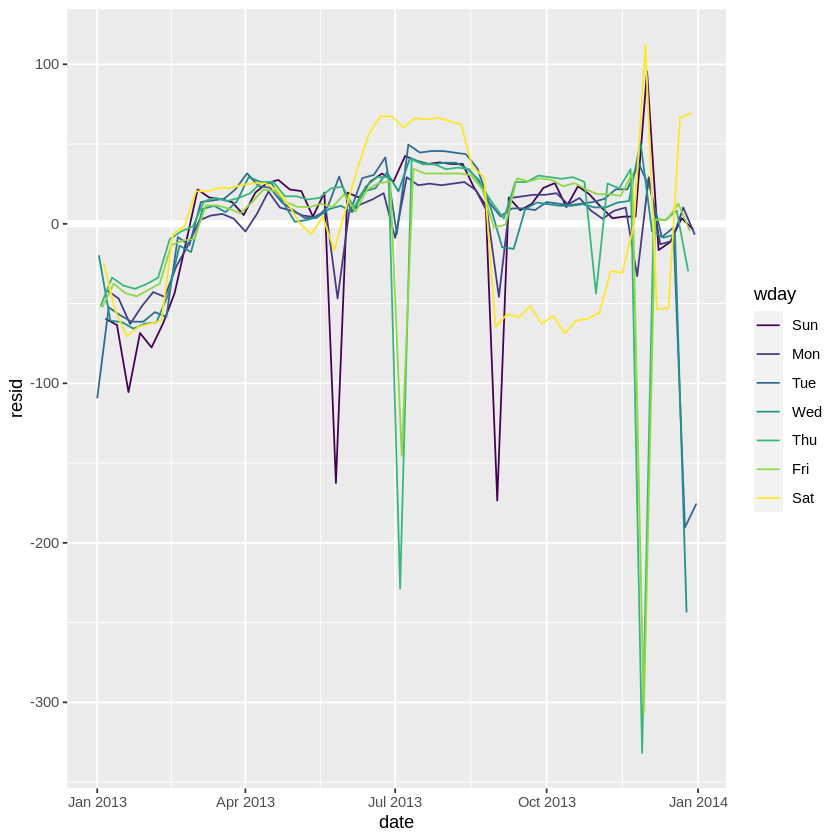

In [32]:
ggplot(daily, aes(date, resid, colour = wday)) + 
  geom_ref_line(h = 0) + 
  geom_line()


  Our model fails to accurately predict the number of flights on Saturday:
    during summer there are more flights than we expect, and during Fall there 
    are fewer. We'll see how we can do better to capture this pattern in the
    next section.

2.  There are some days with far fewer flights than expected:


In [33]:
daily %>% 
  filter(resid < -100)

date,n,wday,resid
<date>,<int>,<ord>,<dbl>
2013-01-01,842,Tue,-109.3585
2013-01-20,786,Sun,-105.4808
2013-05-26,729,Sun,-162.4808
2013-07-04,737,Thu,-228.7500
2013-07-05,822,Fri,-145.4615
2013-09-01,718,Sun,-173.4808
2013-11-28,634,Thu,-331.7500
2013-11-29,661,Fri,-306.4615
2013-12-24,761,Tue,-190.3585



  If you're familiar with American public holidays, you might spot New Year's 
    day, July 4th, Thanksgiving and Christmas. There are some others that don't 
    seem to correspond to public holidays. You'll work on those in one 
    of the exercises.
    
3.  There seems to be some smoother long term trend over the course of a year.
    We can highlight that trend with `geom_smooth()`:


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



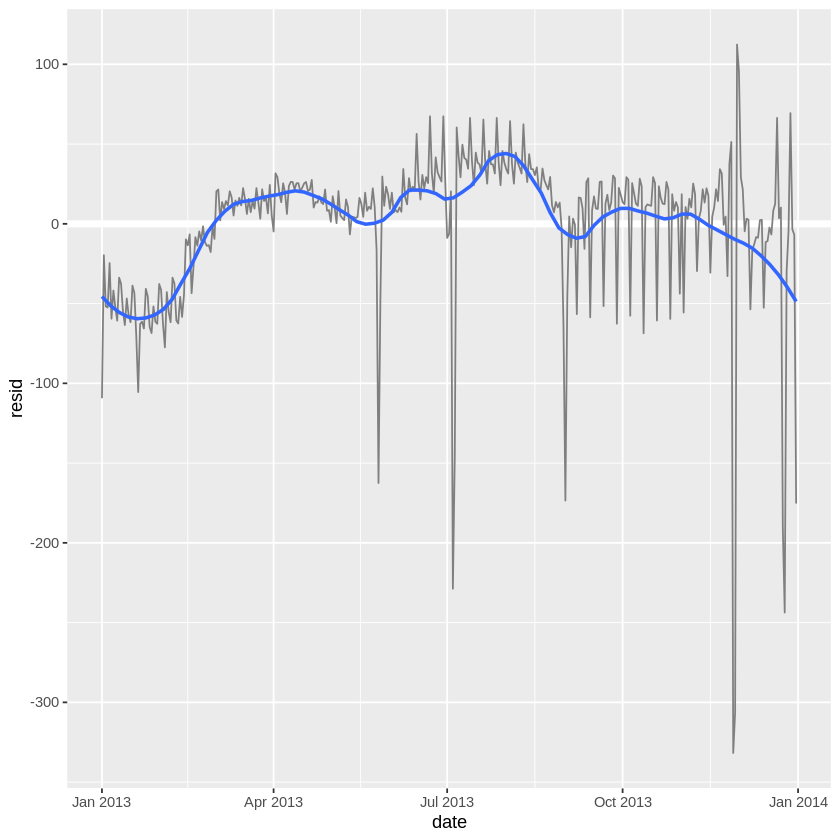

In [34]:
daily %>% 
  ggplot(aes(date, resid)) + 
  geom_ref_line(h = 0) + 
  geom_line(colour = "grey50") + 
  geom_smooth(se = FALSE, span = 0.20)


  There are fewer flights in January (and December), and more in summer 
    (May-Sep). We can't do much with this pattern quantitatively, because we 
    only have a single year of data. But we can use our domain knowledge to 
    brainstorm potential explanations.

### Seasonal Saturday effect

Let's first tackle our failure to accurately predict the number of flights on Saturday. A good place to start is to go back to the raw numbers, focussing on Saturdays:



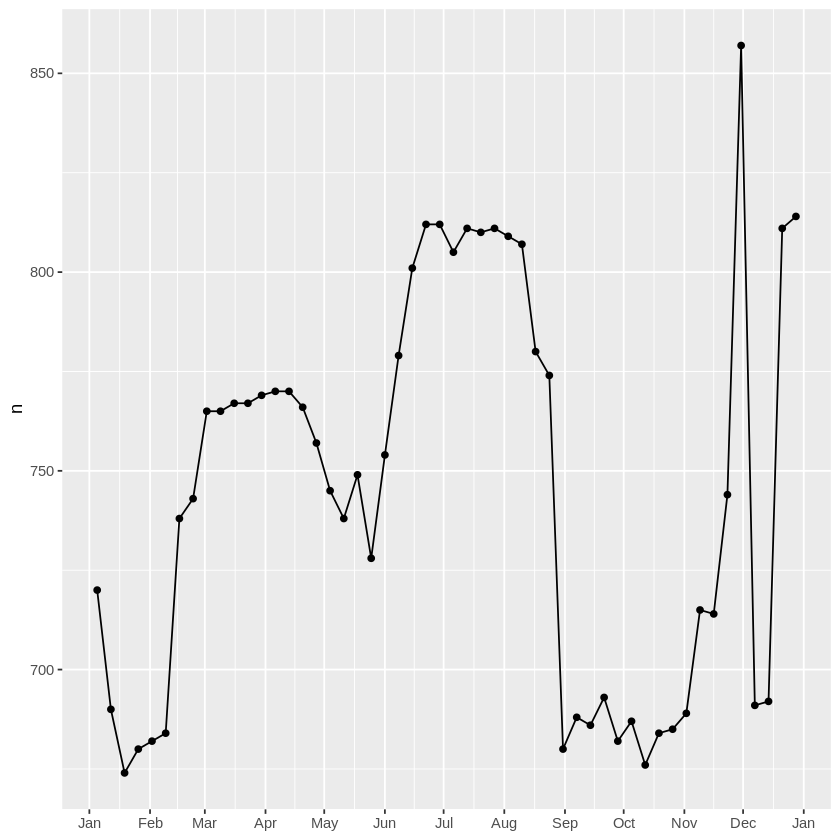

In [35]:
daily %>% 
  filter(wday == "Sat") %>% 
  ggplot(aes(date, n)) + 
    geom_point() + 
    geom_line() +
    scale_x_date(NULL, date_breaks = "1 month", date_labels = "%b")


(I've used both points and lines to make it more clear what is data and what is interpolation.)

I suspect this pattern is caused by summer holidays: many people go on holiday in the summer, and people don't mind travelling on Saturdays for vacation. Looking at this plot, we might guess that summer holidays are from early June to late August. That seems to line up fairly well with the [state's school terms](http://schools.nyc.gov/Calendar/2013-2014+School+Year+Calendars.htm): summer break in 2013 was Jun 26--Sep 9. 

Why are there more Saturday flights in the Spring than the Fall? I asked some American friends and they suggested that it's less common to plan family vacations during the Fall because of the big Thanksgiving and Christmas holidays. We don't have the data to know for sure, but it seems like a plausible working hypothesis.

Lets create a "term" variable that roughly captures the three school terms, and check our work with a plot:



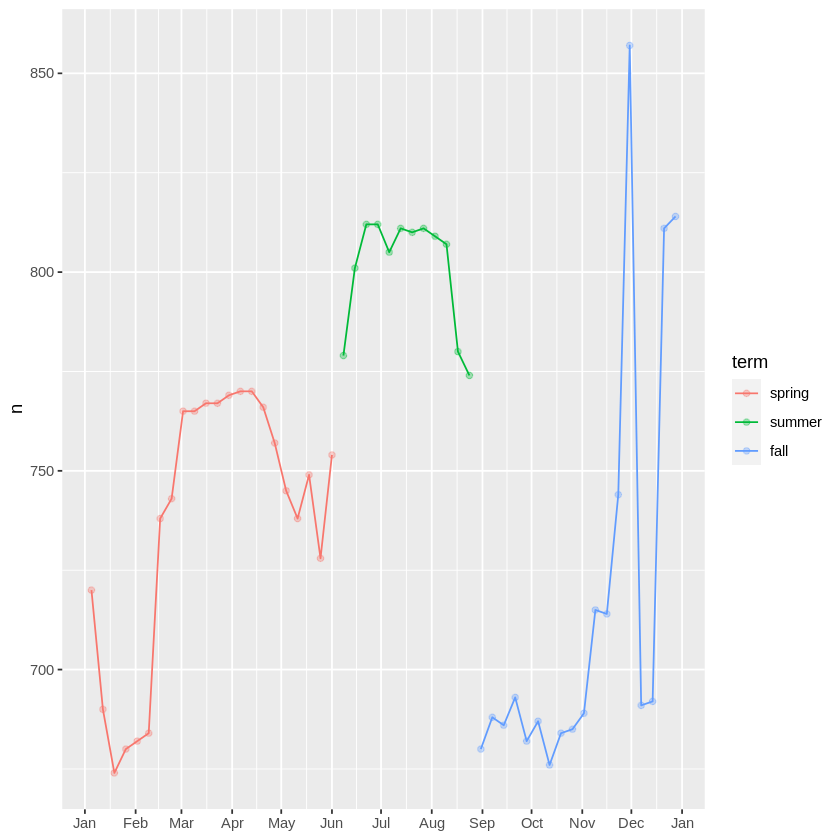

In [36]:
term <- function(date) {
  cut(date, 
    breaks = ymd(20130101, 20130605, 20130825, 20140101),
    labels = c("spring", "summer", "fall") 
  )
}

daily <- daily %>% 
  mutate(term = term(date)) 

daily %>% 
  filter(wday == "Sat") %>% 
  ggplot(aes(date, n, colour = term)) +
  geom_point(alpha = 1/3) + 
  geom_line() +
  scale_x_date(NULL, date_breaks = "1 month", date_labels = "%b")


(I manually tweaked the dates to get nice breaks in the plot. Using a visualisation to help you understand what your function is doing is a really powerful and general technique.)

It's useful to see how this new variable affects the other days of the week:


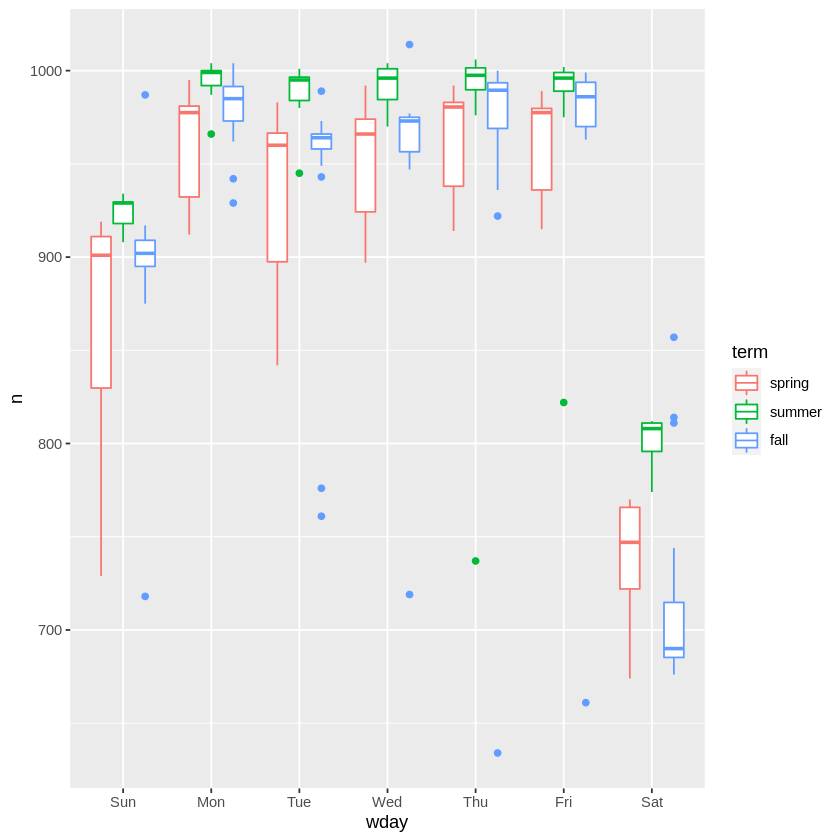

In [37]:
daily %>% 
  ggplot(aes(wday, n, colour = term)) +
    geom_boxplot()


It looks like there is significant variation across the terms, so fitting a separate day of week effect for each term is reasonable. This improves our model, but not as much as we might hope:



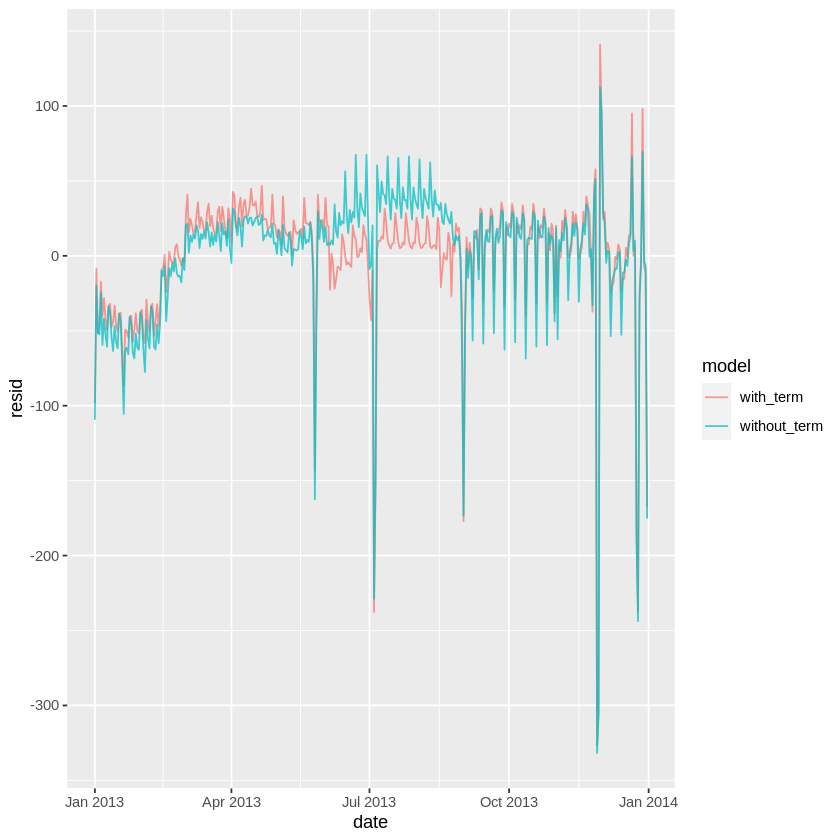

In [38]:
mod1 <- lm(n ~ wday, data = daily)
mod2 <- lm(n ~ wday * term, data = daily)

daily %>% 
  gather_residuals(without_term = mod1, with_term = mod2) %>% 
  ggplot(aes(date, resid, colour = model)) +
    geom_line(alpha = 0.75)


We can see the problem by overlaying the predictions from the model on to the raw data:


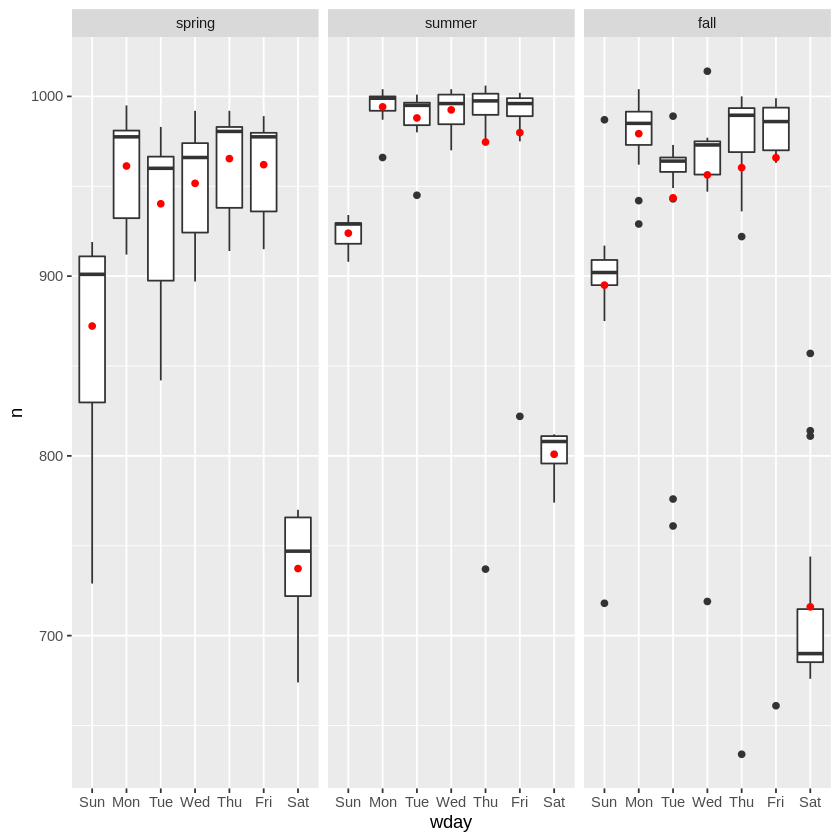

In [39]:
grid <- daily %>% 
  data_grid(wday, term) %>% 
  add_predictions(mod2, "n")

ggplot(daily, aes(wday, n)) +
  geom_boxplot() + 
  geom_point(data = grid, colour = "red") + 
  facet_wrap(~ term)


Our model is finding the _mean_ effect, but we have a lot of big outliers, so mean tends to be far away from the typical value. We can alleviate this problem by using a model that is robust to the effect of outliers: `MASS::rlm()`. This greatly reduces the impact of the outliers on our estimates, and gives a model that does a good job of removing the day of week pattern:



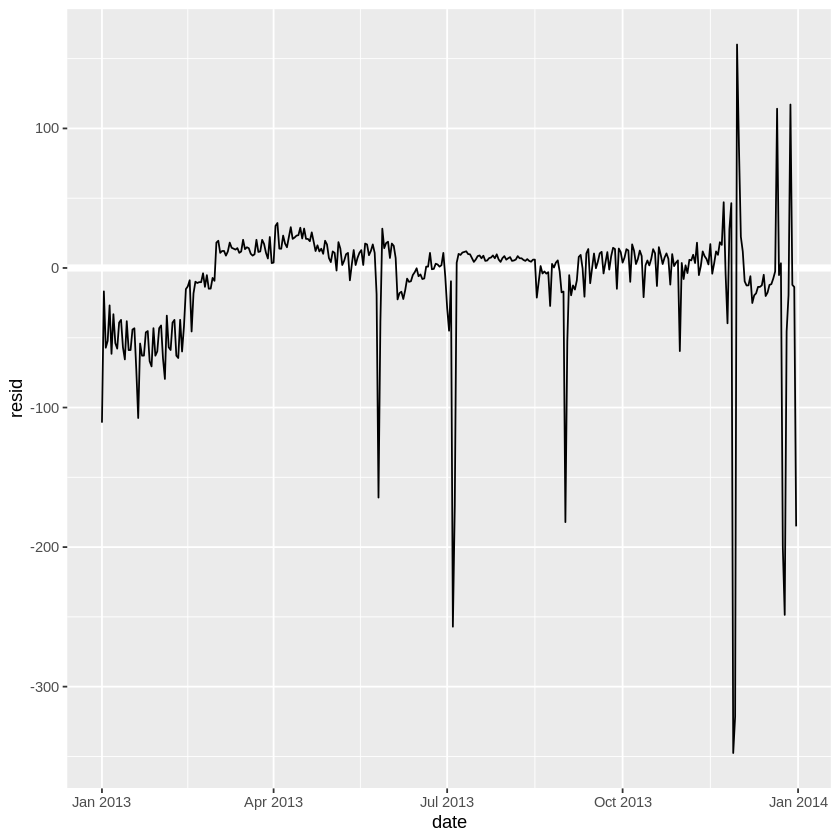

In [40]:
mod3 <- MASS::rlm(n ~ wday * term, data = daily)

daily %>% 
  add_residuals(mod3, "resid") %>% 
  ggplot(aes(date, resid)) + 
  geom_hline(yintercept = 0, size = 2, colour = "white") + 
  geom_line()


It's now much easier to see the long-term trend, and the positive and negative outliers.


### Computed variables

If you're experimenting with many models and many visualisations, it's a good idea to bundle the creation of variables up into a function so there's no chance of accidentally applying a different transformation in different places. For example, we could write:



In [41]:
compute_vars <- function(data) {
  data %>% 
    mutate(
      term = term(date), 
      wday = wday(date, label = TRUE)
    )
}


Another option is to put the transformations directly in the model formula:



In [42]:
wday2 <- function(x) wday(x, label = TRUE)
mod3 <- lm(n ~ wday2(date) * term(date), data = daily)


Either approach is reasonable. Making the transformed variable explicit is useful if you want to check your work, or use them in a visualisation. But you can't easily use transformations (like splines) that return multiple columns. Including the transformations in the model function makes life a little easier when you're working with many different datasets because the model is self contained.

### Time of year: an alternative approach

In the previous section we used our domain knowledge (how the US school term affects travel) to improve the model. An alternative to using our knowledge explicitly in the model is to give the data more room to speak. We could use a more flexible model and allow that to capture the pattern we're interested in. A simple linear trend isn't adequate, so we could try using a natural spline to fit a smooth curve across the year:



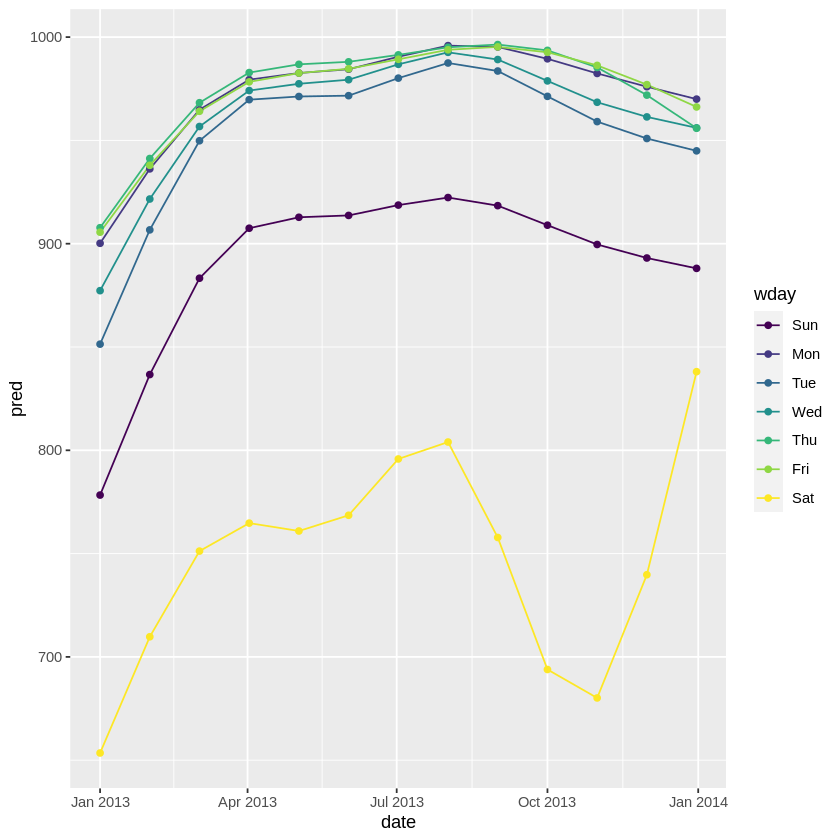

In [43]:
library(splines)
mod <- MASS::rlm(n ~ wday * ns(date, 5), data = daily)

daily %>% 
  data_grid(wday, date = seq_range(date, n = 13)) %>% 
  add_predictions(mod) %>% 
  ggplot(aes(date, pred, colour = wday)) + 
    geom_line() +
    geom_point()


We see a strong pattern in the numbers of Saturday flights. This is reassuring, because we also saw that pattern in the raw data. It's a good sign when you get the same signal from different approaches.


### Exercises

1.  Use your Google sleuthing skills to brainstorm why there were fewer than
    expected flights on Jan 20, May 26, and Sep 1. (Hint: they all have the
    same explanation.) How would these days generalise to another year?

1.  What do the three days with high positive residuals represent?
    How would these days generalise to another year?

    ```r
    daily %>% 
      top_n(3, resid)
    ```

1.  Create a new variable that splits the `wday` variable into terms, but only
    for Saturdays, i.e. it should have `Thurs`, `Fri`, but `Sat-summer`, 
    `Sat-spring`, `Sat-fall`. How does this model compare with the model with 
    every combination of `wday` and `term`?
    
1.  Create a new `wday` variable that combines the day of week, term 
    (for Saturdays), and public holidays. What do the residuals of 
    that model look like?

1.  What happens if you fit a day of week effect that varies by month 
    (i.e. `n ~ wday * month`)? Why is this not very helpful? 

1.  What would you expect the model `n ~ wday + ns(date, 5)` to look like?
    Knowing what you know about the data, why would you expect it to be
    not particularly effective?

1.  We hypothesised that people leaving on Sundays are more likely to be 
    business travellers who need to be somewhere on Monday. Explore that 
    hypothesis by seeing how it breaks down based on distance and time: if 
    it's true, you'd expect to see more Sunday evening flights to places that 
    are far away.

1.  It's a little frustrating that Sunday and Saturday are on separate ends
    of the plot. Write a small function to set the levels of the 
    factor so that the week starts on Monday.



## Learning more about models

We have only scratched the absolute surface of modelling, but you have hopefully gained some simple, but general-purpose tools that you can use to improve your own data analyses. It's OK to start simple! As you've seen, even very simple models can make a dramatic difference in your ability to tease out interactions between variables.

These modelling chapters are even more opinionated than the rest of the book. I approach modelling from a somewhat different perspective to most others, and there is relatively little space devoted to it. Modelling really deserves a book on its own, so I'd highly recommend that you read at least one of these three books:

* *Statistical Modeling: A Fresh Approach* by Danny Kaplan,
  <http://www.mosaic-web.org/go/StatisticalModeling/>. This book provides 
  a gentle introduction to modelling, where you build your intuition,
  mathematical tools, and R skills in parallel. The book replaces a traditional
  "introduction to statistics" course, providing a curriculum that is up-to-date 
  and relevant to data science.

* *An Introduction to Statistical Learning* by Gareth James, Daniela Witten, 
  Trevor Hastie, and Robert Tibshirani, <http://www-bcf.usc.edu/~gareth/ISL/> 
  (available online for free). This book presents a family of modern modelling
  techniques collectively known as statistical learning.  For an even deeper
  understanding of the math behind the models, read the classic 
  *Elements of Statistical Learning* by Trevor Hastie, Robert Tibshirani, and
  Jerome Friedman, <https://web.stanford.edu/~hastie/Papers/ESLII.pdf> (also
  available online for free).

* *Applied Predictive Modeling* by Max Kuhn and Kjell Johnson, 
  <http://appliedpredictivemodeling.com>. This book is a companion to the 
  __caret__ package and provides practical tools for dealing with real-life
  predictive modelling challenges.
